# Titanic at Kaggle 鐵達尼號生存預測(用RFC隨機參森林)
<img src="https://www.ibm.com/support/knowledgecenter/zh-tw/SS3RA7_sub/modeler_crispdm_ddita/clementine/images/crisp_process.jpg">

## step1 Load data 讀資料

In [1]:
#引入套件
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns #資料視覺化

#讀訓練集
data=pd.read_csv('train.csv')
#讀測試集
test= pd.read_csv("test.csv")

#觀察欄位
data.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:
#觀察DataFrame資訊
data.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [3]:
data.describe()
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Step 2 : Prepare Data (preprocessing)
* imputation 補齊data(看有沒有缺值,不然維度不對)
* normalize data
* data type conversion 資料轉換(像男生女生是物件,型別不對)
* find useful features 找到有用的特徵

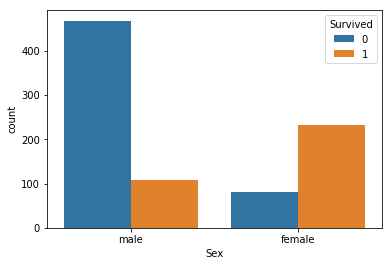

In [4]:
# 我們找 pclass艙等級 age年齡 sex性別 有用的特徵值

# feature Sex 性別跟生存機率 /countplot計數圖
sns.countplot(data['Sex'],hue=data['Survived']) #男生跟女生存活比率(女生比較會活著)
#sns.countplot(data['Survived'],hue=data['Sex']) #要相反過來驗證

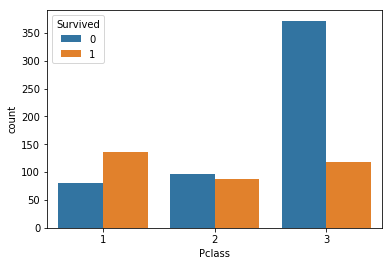

In [5]:
#feature pclass
sns.countplot(data['Pclass'],hue=data['Survived'])#(座1選項頭等艙活的機率比較高)

before imputation=====
S    644
C    168
Q     77
Name: Embarked, dtype: int64
after imputation===
S    646
C    168
Q     77
Name: Embarked, dtype: int64


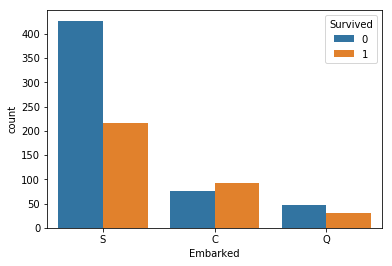

In [6]:
#補空值

# feature Embarked 港口
sns.countplot(data['Embarked'],hue=data['Survived'])#S港口活的比率高

print('before imputation=====')
#print(data[data['Embarked'].isnull()]) # .isnull() #列出是nan的(True的)
print(data['Embarked'].value_counts())#.value_counts()列出不是nan的統計(觀察最多的為S)
#print(data['Embarked'].isnull().value_counts()) # .isnull().value_counts()列出【是否nan】 True false數量(說明有兩個nan)

print('after imputation===')
#補nan值為S(因為S最多)
data['Embarked']=data['Embarked'].fillna('S')
print(data['Embarked'].value_counts()) # S 從644 變 646，補nan成功

In [7]:
# pandas one hot encoding
#實際的機器學習的應用任務中，特徵有時候並不總是連續值，有可能是一些分類值(像是性別1和0沒有大小的意義)，通常我們需要對其進行特徵數字化
#比如size:[X,XL,XXL],那么就使用數值的映射{X:1,XL:2,XXL:3}
data=pd.get_dummies(data=data, columns=['Sex','Pclass','Embarked'] )
test=pd.get_dummies(data=test, columns=['Sex','Pclass','Embarked'] )

#data.head()
#data.columns
#test.head()
test.columns

Index(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [8]:
x=data[['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2','Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].values.reshape(-1,8)
y=data['Survived'].values.reshape(-1,1)#變成numpy.ndarray
print(y.shape,type(y))

testx= test[['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2','Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].values.reshape(-1,8)

(891, 1) <class 'numpy.ndarray'>


# Step 3 : Build model 建置模型

In [9]:
#隨機森林
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.datasets import make_classification

model=RFC()

model.fit(x,y)

score=model.score(x,y)

print("score:",score)

y_pred  = model.predict(x)

testy = model.predict(testx)
test['Survived']=testy

score: 0.8114478114478114


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


# Step 4: Evaluate Model

In [10]:
from sklearn.metrics import classification_report
target_names = ['Die', 'Active']
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Die       0.79      0.95      0.86       549
      Active       0.88      0.58      0.70       342

   micro avg       0.81      0.81      0.81       891
   macro avg       0.84      0.77      0.78       891
weighted avg       0.82      0.81      0.80       891



In [11]:
#交叉驗證 cross_validation
from sklearn.model_selection import cross_validate
cv_results = cross_validate(model, x, y, cv=5)
sorted(cv_results.keys())                         
#['fit_time', 'score_time', 'test_score']
print(cv_results['test_score'].mean())

0.8025084873431929


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was pa

# Step 5 : Write back  test results 寫出檔案

In [12]:
test=test[['PassengerId','Survived']]
test.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [13]:
test.to_csv("submit.csv",index=False,mode='w')